# Analysis of Data

### Import libraries and data

In [1]:
import pandas as pd
import geopandas as gpd
from collections import Counter
import re

from analysis import get_prof_str, plot_ratio_over_time, get_jobs_overtime, make_gif,\
     jobs_not_before_after_specific_year, sort_by_number_of_words, plot_profession_selection_on_map

In [2]:
rich_data = pd.read_pickle("data/unique_aligned_tagged.pkl")
#convert to geopandas dataframe
rich_data = gpd.GeoDataFrame(rich_data, geometry=rich_data.geometry)

# make profession tags usable (from "['profession1', 'profession2']" to "profession1, profession2")
rich_data["tags"] = rich_data["tags"].apply(get_prof_str)

# alternative: rich_data.geometry.representative_point
rich_data["centroid"] = rich_data.geometry.centroid

## Preparation

<AxesSubplot: >

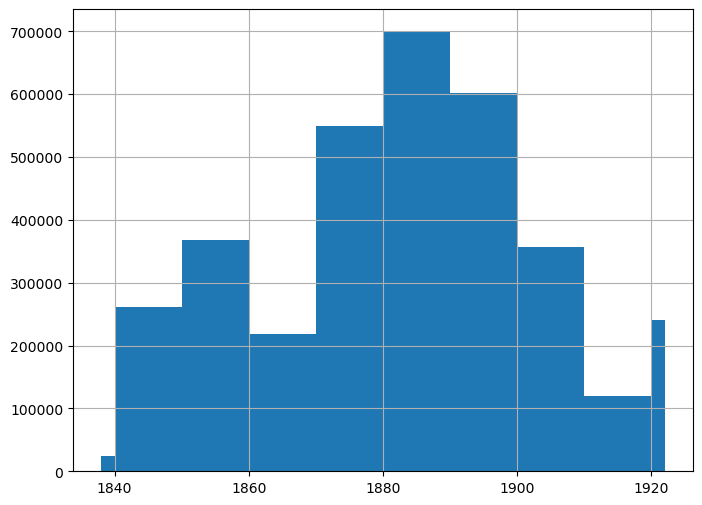

In [ ]:
#binning data: e.g. 1860-1869 -> 1860 (1860s, but in order to keep it an integer, the "s" is ommitted)
rich_data["annee_bin"] = pd.cut(rich_data["annee"], right=False,
                bins=[1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930],
                labels=[1839, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920])
rich_data["annee_bin"].hist(bins=[1838, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1922])

In [ ]:
# get only jobs with frequency in dataset higher than 50
freq_jobs = [metier for metier, count in Counter(rich_data["tags"]).items() if count>50]
print("number of frequent jobs:", len(freq_jobs))

# see how many rows include frequent jobs
print("all rows:", len(rich_data))
freq_job_data = rich_data[rich_data["tags"].isin(freq_jobs)]
print("only rows with frequent jobs:", len(freq_job_data))

number of frequent jobs: 4010
all rows: 3439059
only rows with frequent jobs: 2920181


In [ ]:
# check how the selection of frequent jobs puts bias in data

# create dataframe with absolute frequency of professions in rich_data and freq_job_data
count_year = rich_data.groupby(by="annee").count()[["tags"]]
count_year_freq = freq_job_data.groupby(by="annee").count()[["tags"]]
both_freq = count_year.join(count_year_freq, lsuffix="_all")

# this plot shows that the omitting of jobs with frequency <50 is affecting all years evenly
both_freq.plot.bar(y=["tags_all", "tags"], figsize=(10,6))

NameError: name 'freq_job_data' is not defined

## First Analysis on Professions

In [ ]:
# compare raw profession data and tags
print("Most frequent jobs in profession raw data:", Counter(rich_data["metier"]).most_common(10))
print("Most frequent jobs in tagged data:", Counter(rich_data["tags"]).most_common(10))

Most frequent jobs in profession raw data: [('vins', 223586), ('épicier', 91940), ('médecin', 54067), ('coiffeur', 48743), ('propriétaire', 47738), ('tailleur', 46811), ('boulanger', 43680), ('boucher', 42866), ('architecte', 35107), ('peintre-artiste', 28628)]
Most frequent jobs in tagged data: [('vins', 224584), ('épicier', 93451), ('propriétaire', 71463), ('médecin', 56520), ('coiffeur', 49351), ('tailleur', 48580), ('boulanger', 44561), ('boucher', 43278), ('architecte', 36831), ('artiste, peintre', 34347)]


In [ ]:
#get ratio of top 10 jobs in dataset
top_jobs10 = Counter(freq_job_data["tags"]).most_common(10)
top_jobnames10 = [name for name, count in top_jobs10]
plot_ratio_over_time(rich_data, top_jobnames10, title="Development top 10 jobs in dataset")

NameError: name 'freq_job_data' is not defined

## Street statistics

In [ ]:
#look at most frequent streets
top_streets20 = Counter(rich_data["streetname"]).most_common(20)
top_streets20 = [name for name, count in top_streets20]

plot_ratio_over_time(rich_data, top_streets20, col_name="streetname",
        title="Development of most frequent streets in dataset")

### Looking at one street

In [ ]:
oberkampf_jobs = get_jobs_overtime(rich_data, "Rue Oberkampf")
plot_ratio_over_time(rich_data, oberkampf_jobs, title="Top job development in street 'Rue Oberkampf'")

In [ ]:
stgermain_jobs = get_jobs_overtime(rich_data, "Boulevard Saint-Germain")
plot_ratio_over_time(rich_data, stgermain_jobs, title="Top job development in street 'Boulevard Saint-Germain'")

### Most changing jobs

In [ ]:
#safe number of bottin entries per year in a dict {year: #entries}
count_per_year = rich_data.groupby("annee").count()
count_per_year = dict(zip(count_per_year.index, count_per_year["row"]))
#count_per_year

In [ ]:
df = rich_data.groupby(["tags", "annee"]).count()[["row"]]
df["job_ratio_by_year"] = df.apply(lambda x: x.row/count_per_year[x.name[1]], axis=1)
df


In [ ]:
df_ratio = df[["job_ratio_by_year"]].groupby("tags").std().dropna().sort_values(by="job_ratio_by_year", ascending=False)
std_list = list(df_ratio.reset_index().head(20)["tags"])

In [ ]:
plot_ratio_over_time(rich_data, std_list, title="Most changing job ratios over time")

### Looking at certain jobs

In [ ]:
chaussures = rich_data[rich_data["tags"]=="chaussures"]
chaussures.groupby("annee").count()[["row"]].plot.line()

In [ ]:
proprietaire = rich_data[rich_data["tags"]=="propriétaire"]
proprietaire.groupby("annee").count()[["row"]].plot.line()

# Professions which were born or died out

In [ ]:
not_after1880, not_before1880 = jobs_not_before_after_specific_year(freq_job_data, 1880)

not_bef1880_one, _, _ = sort_by_number_of_words(not_before1880)
not_aft1880_one, _, _ = sort_by_number_of_words(not_after1880)
print("new profession entries - only after 1880 (one word entries):\n", not_bef1880_one, 
        "\n\nold profession entries - only before 1880 (one word entries):\n", not_aft1880_one)


In [ ]:
plot_ratio_over_time(rich_data, not_aft1880_one+not_bef1880_one, 
            title="Jobs which died out before or appeared after 1880")

### Working with geodata

In [ ]:
for year in [1922]:#sorted(rich_data["annee"].unique()):
    plot_profession_selection_on_map(rich_data, professions=["horloger", "modes"], year=year)

In [ ]:
#make_gif(sorted(rich_data["annee"].unique()))

# Heatmaps
### with code from
https://nbviewer.org/gist/perrygeo/c426355e40037c452434

C:\Users\Lea\AppData\Local\Temp/ipykernel_12432/2758244975.py:24: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
C:\Users\Lea\AppData\Local\Temp/ipykernel_12432/2758244975.py:26: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')


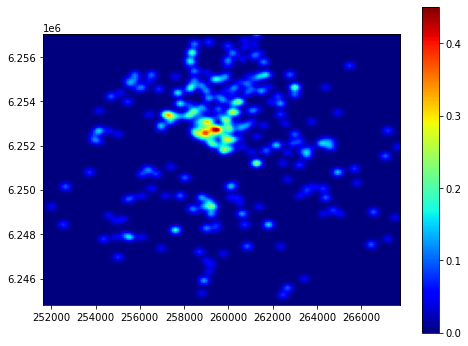

In [ ]:
import geopandas as gpd
import numpy as np
from scipy import ndimage

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = 8, 6

pts = rich_data[(rich_data["annee"]==1922) & (rich_data["metier"] == "modes")]
pts = pts.rename(columns={"geometry":"geo_col", "centroid":"geometry"})

def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

heatmap(pts, bins=150, smoothing=1.5)
